# 1. Noise-free data

In [88]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import special_ortho_group

## 1.1

In [89]:
def simulate_sir_simple(lam, mu, I_0, T):
    """
    simulates the epidemy using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0
    
    # Lists to store observations and ODE variables
    X = np.zeros((T, 2))
    C = np.zeros((T, 3))
    
    for day in range(T):
        
        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X[day] = [dS,dR]
        C[day] = [S, I, R]

    
    return X, C


## 1.2

In [90]:
def plot_sir_simulation(C, title='SIR Model Simulation'):
    """
    Plots the SIR simulation results.

    C: Array containing the S, I, R values at each timestep
    T: Total number of days in the simulation
    """
    days = range(len(C))

    # Extract S, I, R values
    S, I, R = C[:,0], C[:,1], C[:,2]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(days, S, label='Susceptible')
    plt.plot(days, I, label='Infected')
    plt.plot(days, R, label='Recovered')

    plt.xlabel('Days')
    plt.ylabel('Population Proportion')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

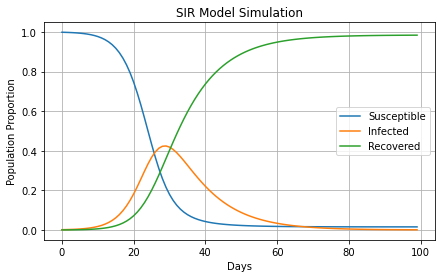

In [91]:
lambda_val = 0.4 
mu_val = 0.1     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

After some trial and error we found values $\lambda$ = 0.25, $\mu$ = 0.1, and $I_0$ = 0.001 that exhibit interesting and diverse dynamics. Now we look at the ranges of each value where we still see interesting dynamics

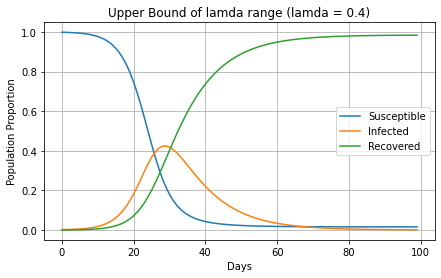

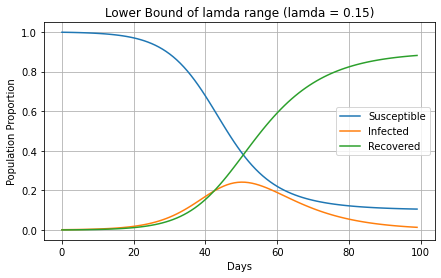

In [5]:
lambda_val_1 = 0.40
lambda_val_2 = 0.25

X_1, C_1 = simulate_sir_simple(lambda_val_1, mu_val, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val_2, mu_val, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of lamda range (lamda = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of lamda range (lamda = 0.15)")

So lambda should be in the range between $\lambda = [0.25, 0.4]$. Lets do the same with $\mu$ and $I_0$

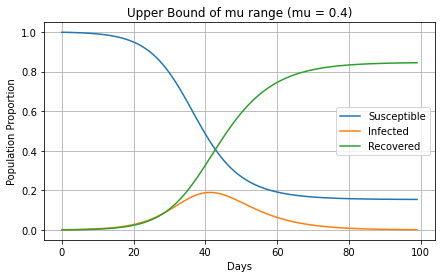

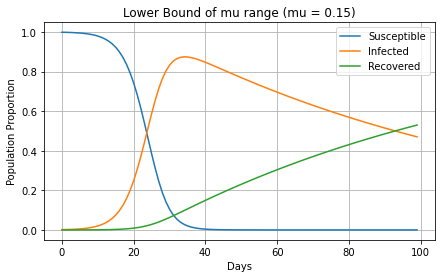

In [6]:
mu_val_1 = 0.15
mu_val_2 = 0.01
lambda_val = 0.325

X_1, C_1 = simulate_sir_simple(lambda_val, mu_val_1, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val_2, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of mu range (mu = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of mu range (mu = 0.15)")

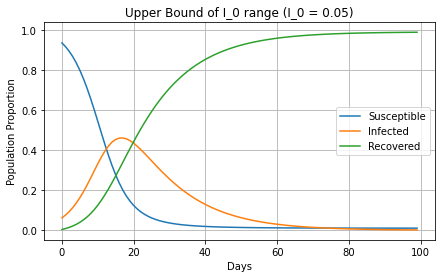

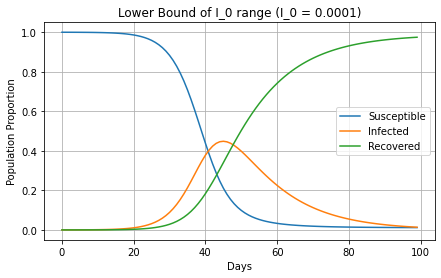

In [7]:
mu_val = 0.075
initial_infected_1 = 0.05  
initial_infected_2 = 0.0001  


X_1, C_1 = simulate_sir_simple(lambda_val, mu_val, initial_infected_1, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val, initial_infected_2, num_days)

plot_sir_simulation(C_1, title="Upper Bound of I_0 range (I_0 = 0.05)")
plot_sir_simulation(C_2, title="Lower Bound of I_0 range (I_0 = 0.0001)")

From our test we get suitable range of:   
$\lambda = [0.25, 0.4]$
$\mu = [0.01, 0.15]$
$I_0 = [0.0001, 0.05]$

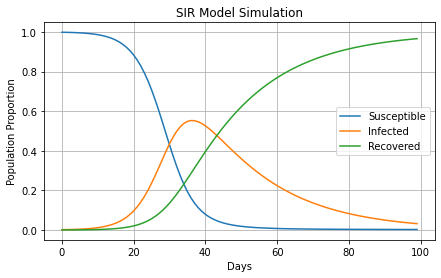

In [8]:
lambda_val = 0.3 
mu_val = 0.05     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

## 1.3

First, we define a dataset for training:

In [92]:
class SIRDataset(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)  
        mu_prior = np.random.uniform(0.01, 0.15, size=size)  
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)
        
        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            X, _ = simulate_sir_simple(lam, mu, I_0, T)
            self.data.append(X)
            self.targets.append([lam, mu, I_0])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

Next, we define a network architecture and train it on our datasets

In [93]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, 3))  # Output layer

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x
    
def train_network(net, train_loader, validation_loader, optimizer, criterion, epochs=5):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        # Train:
        train_loss = 0
        net.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
        
        # Validate: 
        net.eval()
        validation_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                outputs = net(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        validation_loss = validation_loss/len(validation_loader)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(f"[{epoch}/{epochs}] train loss: {train_loss}, validation loss: {validation_loss}")

    return train_losses, validation_losses

def evaluate_network(net, test_loader, criterion):
    with torch.no_grad():
        test_loss = 0
        for data, targets in test_loader:
            outputs = net(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        test_loss = test_loss/len(test_loader)
    return test_loss

def plot_losses(validation_loss, train_loss = None, label="validation"):
    if train_loss is not None:
        plt.plot(train_loss, label="training")
    plt.plot(validation_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

In [94]:
train_dataset = SIRDataset(size=1000, T=100)
validation_dataset = SIRDataset(size=200, T=100) 
test_dataset = SIRDataset(size=200, T=100) 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

[0/10] train loss: 0.012711111106909811, validation loss: 0.002592089702375233
[1/10] train loss: 0.0014035902640898712, validation loss: 0.0011600732188006596
[2/10] train loss: 0.0010321880799892824, validation loss: 0.0009035254562539714
[3/10] train loss: 0.0009013338658405701, validation loss: 0.0008209527919201978
[4/10] train loss: 0.0007881343426561216, validation loss: 0.0007326364949611681
[5/10] train loss: 0.0007186698894656729, validation loss: 0.0006324530570834343
[6/10] train loss: 0.0006432807458622847, validation loss: 0.0006134296501321452
[7/10] train loss: 0.0005919751429246389, validation loss: 0.0005448063727401729
[8/10] train loss: 0.0005618968370981747, validation loss: 0.000533991543176983
[9/10] train loss: 0.0005229846346992417, validation loss: 0.0005415402327863765


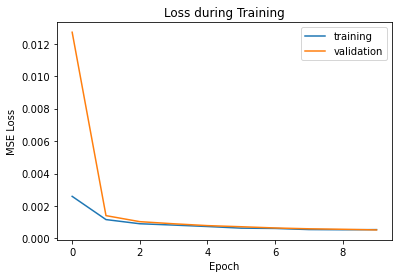

In [12]:
net = SIRNet(input_size=100*2, hidden_size=50, n_hidden_layers=0)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss,validation_loss = train_network(net, train_loader,validation_loader, optimizer, criterion, 10)
plot_losses(train_loss, validation_loss)
plt.title("Loss during Training")
plt.legend()
plt.show()


In [13]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [10, 50, 100]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size, n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _,validation_loss = train_network(net, train_loader,validation_loader, optimizer, criterion, 10)
        


[0/10] train loss: 0.12214429234154522, validation loss: 0.10741310779537473
[1/10] train loss: 0.09914842061698437, validation loss: 0.08908592164516449
[2/10] train loss: 0.07980517786927521, validation loss: 0.06904933814491544
[3/10] train loss: 0.062136176391504705, validation loss: 0.05274906222309385
[4/10] train loss: 0.04578558134380728, validation loss: 0.037713076387132914
[5/10] train loss: 0.03086661745328456, validation loss: 0.023277295221175467
[6/10] train loss: 0.018747122870991006, validation loss: 0.013343839107879571
[7/10] train loss: 0.01027421368053183, validation loss: 0.0067352246093962875
[8/10] train loss: 0.005173026460397523, validation loss: 0.003180827629486365
[9/10] train loss: 0.002718421510508051, validation loss: 0.0020009026962465475
[0/10] train loss: 0.09983855579048395, validation loss: 0.06392924647246088
[1/10] train loss: 0.044774958631023765, validation loss: 0.028474230585353717
[2/10] train loss: 0.020267503045033664, validation loss: 0.01

[0/20] train loss: 0.009797117847483605, validation loss: 0.00308561504685453
[1/20] train loss: 0.001666012318310095, validation loss: 0.0011334570590406656
[2/20] train loss: 0.00105405039175821, validation loss: 0.0009054601957489337
[3/20] train loss: 0.000910614849999547, validation loss: 0.0008057604593757008
[4/20] train loss: 0.0007930179017421324, validation loss: 0.0006976599023411316
[5/20] train loss: 0.000681039640767267, validation loss: 0.0006421930655570966
[6/20] train loss: 0.0005991678435748327, validation loss: 0.0005667657865810075
[7/20] train loss: 0.0005494758142958744, validation loss: 0.0005218225290134017
[8/20] train loss: 0.0005299410113366321, validation loss: 0.0005114963070289898
[9/20] train loss: 0.0005119468751217937, validation loss: 0.0005194425175432116
[10/20] train loss: 0.000508721324877115, validation loss: 0.0005246049009396561
[11/20] train loss: 0.00049842249154608, validation loss: 0.0005396187854265529
[12/20] train loss: 0.000499971220051

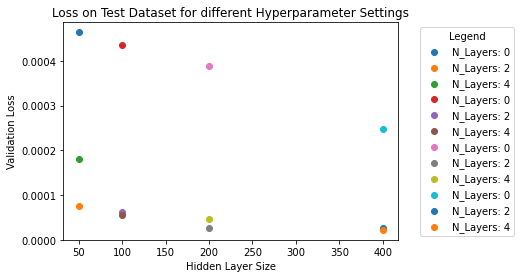

In [14]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [50, 100, 200, 400]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size, n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _,_ = train_network(net, train_loader,validation_loader, optimizer, criterion, 20)
        test_loss = evaluate_network(net, test_loader, criterion)

        plt.scatter(hidden_size, test_loss, label=f'N_Layers: {n_layer}')
        

plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')
# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('Loss on Test Dataset for different Hyperparameter Settings')
plt.show()

We see the larger the network the better the performance in our case and we get the best results for 4 layers and a hidden size of 400. We can also observe that having more layers in these tests have a stronger influence on the outcome than the hidden size. For now we stick with our found network parameter since they perform good enough for our case.  

Lets now look into variable dataset sizes

[0/20] train loss: 0.0073571155007812195, validation loss: 0.0016114316947226013
[1/20] train loss: 0.0013545350557251368, validation loss: 0.0012731824036953704
[2/20] train loss: 0.0012134369717387017, validation loss: 0.0012212033616378903
[3/20] train loss: 0.0011805024223576766, validation loss: 0.001244766837252038
[4/20] train loss: 0.0011425616939959582, validation loss: 0.001157689224263387
[5/20] train loss: 0.001101672834920464, validation loss: 0.0011085032186071788
[6/20] train loss: 0.0010335831284464803, validation loss: 0.0010020948414291655
[7/20] train loss: 0.0009548025736876298, validation loss: 0.0009527542611717113
[8/20] train loss: 0.0009095364439417608, validation loss: 0.0008758909617816764
[9/20] train loss: 0.0008682129409862682, validation loss: 0.0008793350092933647
[10/20] train loss: 0.0008171055014827289, validation loss: 0.0008184863836504519
[11/20] train loss: 0.000725374598914641, validation loss: 0.0006710791411543531
[12/20] train loss: 0.00050375

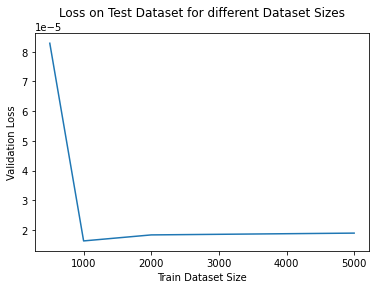

In [15]:
trainset_sizes = [500, 1000, 2000, 5000]
test_losses = []
for train_size in trainset_sizes:
    train_dataset = SIRDataset(size=train_size, T=100)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    net = SIRNet(input_size=100*2, hidden_size=400, n_hidden_layers=4)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    _,_ = train_network(net, train_loader,validation_loader, optimizer, criterion, 20)
    test_loss = evaluate_network(net, test_loader, criterion)
    test_losses.append(test_loss)

        
plt.plot(trainset_sizes, test_losses)

plt.xlabel('Train Dataset Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')

plt.title('Loss on Test Dataset for different Dataset Sizes')
plt.show()

We can't see any substantial improvements after a dataset size of 1000

## 1.4

In [95]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, feature_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, feature_size)) 

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [96]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model

def ortogonal_matrix(dim):
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)

class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]

        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[...,:self.split2], params[...,self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1,x2], -1), ljd
        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1,x2], -1)
        

class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([ConditionalCouplingBlock(input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(input_size) for _ in range(n_blocks-1)]
    
    def forward(self, x, cond, rev=False):
        if rev: return self._inverse(x, cond)
        return self._forward(x, cond)
    
    def _forward(self, x, cond):
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd
    
    def _inverse(self, x, cond):
        for l in range (self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x
    
    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c*torch.ones(num_samples)))
        else:
            z = torch.normal(mean=torch.zeros((num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond*torch.ones(num_samples)))
        return torch.cat(samples, 0)

In [84]:
### conditional real NVP class
class FusionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_sir, feature_size, n_layers_sir, hidden_size_nvp, condition_size, blocks):

        super(FusionNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size_sir = hidden_size_sir
        self.feature_size = feature_size
        self.n_layers = n_layers_sir
        self.hidden_size_nvp = hidden_size_nvp
        self.condition_size = condition_size
        self.blocks = blocks

        self.summary_net = SIRNet(input_size=self.input_size, 
                                  hidden_size=self.hidden_size_sir, 
                                  n_hidden_layers=self.n_layers,
                                  feature_size=feature_size)
        self.real_nvp = ConditionalRealNVP(input_size = feature_size, 
                                           hidden_size = hidden_size_nvp, 
                                           n_blocks = blocks,
                                            condition_size=condition_size )


    def forward(self, x, condition):
        x = self.summary_net(x)
        x = self.real_nvp(x, condition)
        return x


In [85]:
def train_fusion(model, train_loader, validation_loader, batchsize=32, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    model.train()
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss_sum = 0
        model.train()
        for input, ground_truth in train_loader:
            optimizer.zero_grad()
            z, ljd = model(input, ground_truth)
            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
        validation_loss_sum = 0
        model.eval()
        with torch.no_grad():
            for input, ground_truth in validation_loader:
                z, ljd = model(input, ground_truth)
                loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
                validation_loss_sum += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_sum/len(train_loader):.4f}, Validation Loss: {validation_loss_sum/len(validation_loader)}")


Training both networks together:

In [86]:
params = {'input_size' : 2*100,
          'hidden_size_sir' : 200,
          'feature_size' : 50,
          'n_layers_sir' : 4,
          'hidden_size_nvp' : 200,
          'condition_size' : 3,
          'blocks' : 10}

train_dataset = SIRDataset(size=1000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FusionNetwork(**params)
train_fusion(model, train_loader,validation_loader, epochs=100)

Epoch [1/100], Train Loss: -73.0152, Validation Loss: -115.7891366141183
Epoch [2/100], Train Loss: -113.2904, Validation Loss: -85.01251193455288
Epoch [3/100], Train Loss: -128.6357, Validation Loss: -144.8861242021833
Epoch [4/100], Train Loss: -127.9941, Validation Loss: -137.00298854282923
Epoch [5/100], Train Loss: -144.0684, Validation Loss: -109.20069803510394
Epoch [6/100], Train Loss: -148.5736, Validation Loss: -120.37821306501117
Epoch [7/100], Train Loss: -154.5585, Validation Loss: -112.65480422973633
Epoch [8/100], Train Loss: -154.9400, Validation Loss: -165.62260709490096
Epoch [9/100], Train Loss: -140.8604, Validation Loss: -156.61087145124162
Epoch [10/100], Train Loss: -112.6046, Validation Loss: -131.7378202165876
Epoch [11/100], Train Loss: -168.5169, Validation Loss: -159.47068568638392
Epoch [12/100], Train Loss: -139.0770, Validation Loss: -157.73281860351562
Epoch [13/100], Train Loss: -163.6941, Validation Loss: -151.1755872453962
Epoch [14/100], Train Loss:

In [87]:
def generate_predictions(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for input, ground_truth in test_loader:
            z, _ = model(input, ground_truth)
            predictions.append(z)
            ground_truths.append(ground_truth)
    return predictions, ground_truths

test_dataset = SIRDataset(size=10, T=100)
input, ground_truth = test_dataset[0]
input = input.unsqueeze(0)
ground_truth = ground_truth.unsqueeze(0)
z, _ = model(input, ground_truth)
print(z.shape)

torch.Size([1, 50])


# 2. Noisy data

# 3. Model misspecification detection

# 4. Sensitivity analysis